## 3 - Etapa de processamento dos dados

Nesta etapa faremos a **seleção de variáveis**, **seleção de algoritmos**, **seleção de modelos de aprendizagem**, **seleção de métricas de avaliação** e aplicaremos técnicas de amostragem para estabelecer a divisão dos **dados de treino** e **dados de teste** dos algoritmos.

In [1]:
## Pacotes utilizados 

import pandas as pd 
import numpy as np 
import seaborn as sea
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Normalização 
from sklearn.preprocessing import MinMaxScaler
## Padronização 
from sklearn.preprocessing import StandardScaler

# Divisão treino/teste 
from sklearn.model_selection import train_test_split

# Métricas 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

# Algoritmos de aprendizagem 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Otimização 
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
#### Dataframe 

df = pd.read_csv('dados/df_bruto.csv')
df_transf = pd.read_csv('dados/df_transf.csv')
df_transf.shape

(1338, 266)

In [3]:
df_transf.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


### 3.1) Tratamento dos dados 

#### Tratando outliers 

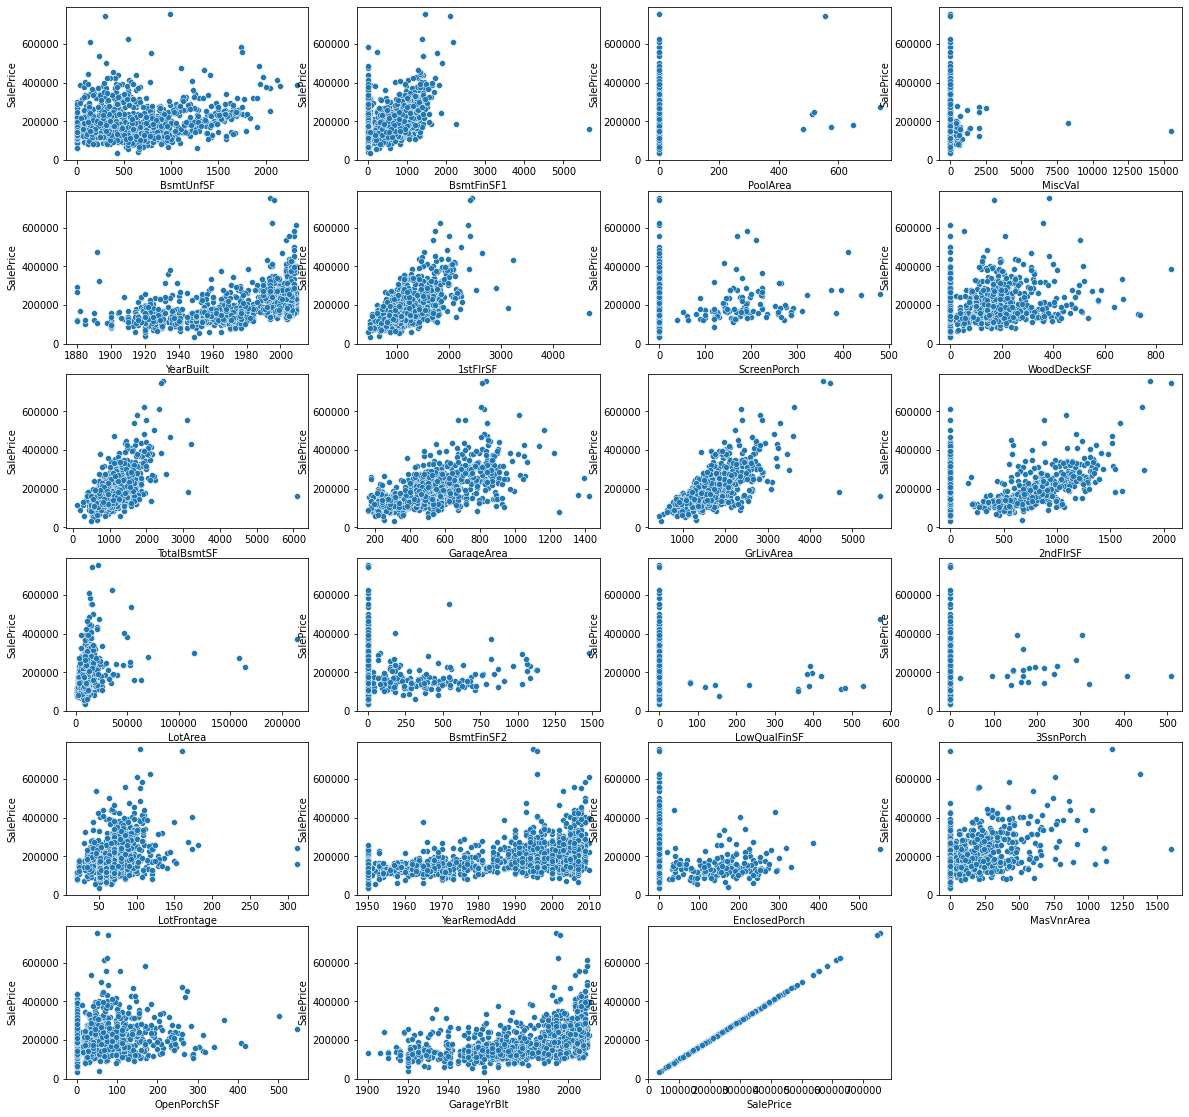

In [4]:
# Variáveis quantitativas.

quant_var = ['BsmtUnfSF', 'BsmtFinSF1', 'PoolArea', 'MiscVal', 'YearBuilt', '1stFlrSF', 'ScreenPorch', 'WoodDeckSF',
             'TotalBsmtSF', 'GarageArea', 'GrLivArea', '2ndFlrSF', 'LotArea', 'BsmtFinSF2', 'LowQualFinSF',
             '3SsnPorch', 'LotFrontage', 'YearRemodAdd', 'EnclosedPorch', 'MasVnrArea', 'OpenPorchSF', 'GarageYrBlt', 
             'SalePrice']

df_quant_var = df_transf[quant_var]

plt.figure(figsize = (20,40))
x = 1
for variavel in df_quant_var.columns:
    plt.subplot(12, 4, x)
    sea.scatterplot(data = df, x = variavel, y = 'SalePrice')
    x += 1

In [5]:
# Eliminando os outliers 

df_trat = df_transf

df_trat = df_trat.drop(df_trat['BsmtUnfSF'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['BsmtFinSF1'].sort_values(ascending = False)[:1].index)
df_trat = df_trat.drop(df_trat['PoolArea'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['MiscVal'].sort_values(ascending = False)[:4].index)
df_trat = df_trat.drop(df_trat['1stFlrSF'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['ScreenPorch'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['WoodDeckSF'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['TotalBsmtSF'].sort_values(ascending = False)[:1].index)
df_trat = df_trat.drop(df_trat['GarageArea'].sort_values(ascending = False)[:4].index)
df_trat = df_trat.drop(df_trat['GrLivArea'].sort_values(ascending = False)[:4].index)
df_trat = df_trat.drop(df_trat['2ndFlrSF'].sort_values(ascending = False)[:4].index)
df_trat = df_trat.drop(df_trat['LotArea'].sort_values(ascending = False)[:5].index)
df_trat = df_trat.drop(df_trat['BsmtFinSF2'].sort_values(ascending = False)[:1].index)
df_trat = df_trat.drop(df_trat['LowQualFinSF'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['3SsnPorch'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['LotFrontage'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['EnclosedPorch'].sort_values(ascending = False)[:2].index)
df_trat = df_trat.drop(df_trat['MasVnrArea'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['OpenPorchSF'].sort_values(ascending = False)[:3].index)
df_trat = df_trat.drop(df_trat['SalePrice'].sort_values(ascending = False)[:3].index)

df_trat.shape

(1283, 266)

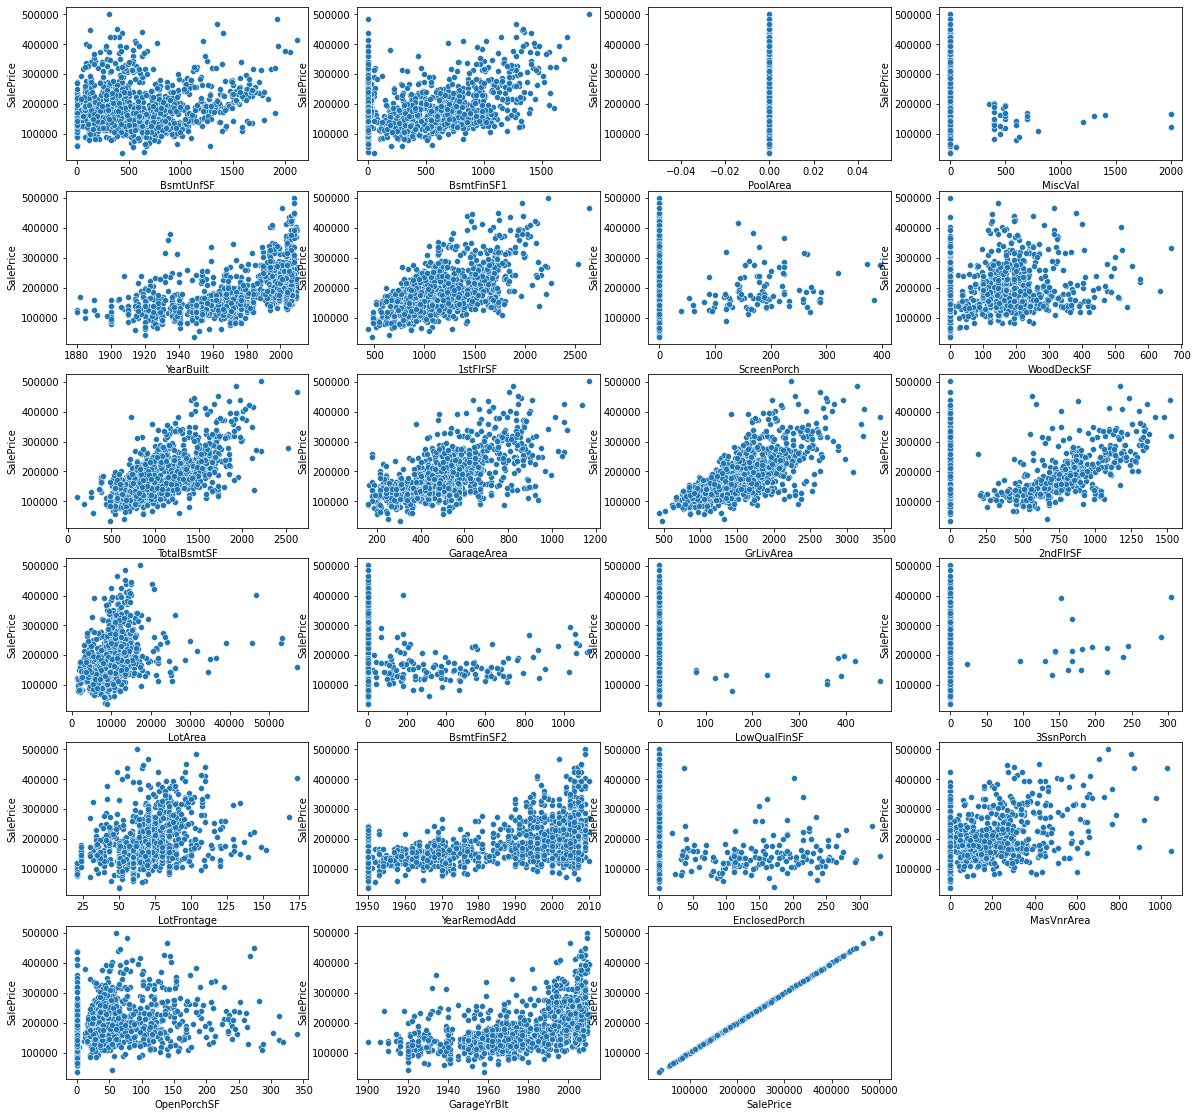

In [6]:
df_quant_var = df_trat[quant_var]

plt.figure(figsize = (20,40))
x = 1
for variavel in df_quant_var.columns:
    plt.subplot(12, 4, x)
    sea.scatterplot(data = df_trat, x = variavel, y = 'SalePrice')
    x += 1

#### Tratando a forma 

Iremos aplicar uma **tranformação de log(x + 1)**  para tornar a distribuição dos dados mais próximas de uma distribuição normal. 

In [7]:
# Dataframe obtido após a remoção dos outliers. 

df_trat.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,0,0,1,0,0,0,0,1,0
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,0,0,0,1,0,0,0,0,1,0
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,0,0,1,0,0,0,0,1,0
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,0,0,1,1,0,0,0,0,0
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,0,0,0,1,0,0,0,0,1,0


In [8]:
df_trat_log = df_trat.copy()

In [9]:
# Dataframe obtido após a transformação de log(x+1).

df_trat_log[quant_var] = np.log1p(df_trat_log[quant_var])
df_trat_log.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,60,4.189655,9.042040,7,5,7.602900,7.602900,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,20,4.394449,9.169623,6,8,7.589336,7.589336,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,60,4.234107,9.328212,7,5,7.601902,7.602401,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,70,4.110874,9.164401,7,5,7.557995,7.586296,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,60,4.442651,9.565284,8,5,7.601402,7.601402,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


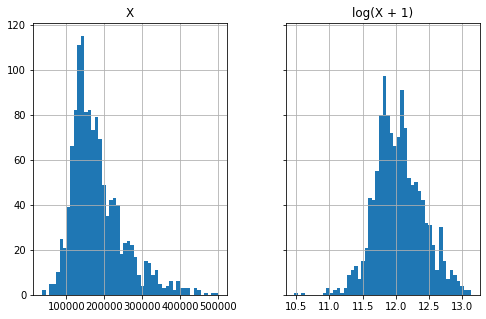

In [10]:
# Exemplo para ilustrar o tratamento de forma. 

x = {"X":df_trat["SalePrice"], "log(X + 1)":np.log1p(df_trat["SalePrice"])}
dados = pd.DataFrame(x)
matplotlib.rcParams['figure.figsize'] = (8.0, 5.0)
dados.hist(sharex = False, sharey = True, bins = 50)
plt.show()

### 3.2) Seleção de métricas

#### Métricas utilizadas

Para avaliação de todos os modelos utilizaremos as três métricas descritas abaixo, um modelo que tiver avaliações melhores em **duas ou mais** métricas será o escolhido, em todas as comparações realizadas. 

**R²**: calcula qual a porcentagem da variância que pode ser prevista pelo modelo, por exemplo, R² = XX significa que XX% da variância dos dados pode ser explicada pelo modelo. Essa métrica varia de 0 a 1 e quanto mais próximo de 1, melhor é o modelo. 

**MAPE**: exprime uma porcentagem, significando que, em média, o modelo faz previsões que erram por XX% do valor real, ou seja, quanto menor o MAPE, melhor é o modelo. 

**RMSE**: métrica utilizada como uma forma de melhorar a interpretabilidade do erro, pois nela o erro será expresso em unidades da variável alvo, assim quanto menor o RMSE, melhor é o modelo.  

In [11]:
# Funções para aplicar as métricas 

def metricas(y_teste, y_pred):
    rmse = (mean_squared_error(y_teste, y_pred))**(1/2)
    print("R² = %.2f %%" % (r2_score(y_teste, y_pred)*100))
    print("MAPE = %.2f %% " % (mean_absolute_percentage_error(y_teste, y_pred)*100))
    print("RMSE = %.2f USD" % (rmse)) 
    
def valores_metricas(y_teste, y_pred):
    r2 = (r2_score(y_teste, y_pred)*100)
    mape = (mean_absolute_percentage_error(y_teste, y_pred)*100)
    rmse = (mean_squared_error(y_teste, y_pred))**(1/2)
    return [r2, mape, rmse]

### 3.3) Seleção de algoritmo de aprendizagem

#### Modelo base 

O **modelo base** utilizará o algoritmo de **regressão linear multivariada** e o conjunto de dados sem nenhum tipo de tratamento de forma, outliers ou seleção de variáveis, ou seja, será treinado com o **dataframe pré-processado** ( apenas sem os valores missing), utilizando **amostragem estática (train_test_split)**. 

In [12]:
# Divide os dados em treino e teste
variaveis = list(df_transf.columns)
variaveis.remove('SalePrice')

X = df_transf[variaveis].values
Y = df_transf['SalePrice'].values

x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.30, random_state = 5)

# Criando e treinando o modelo
modelo = LinearRegression(normalize = False).fit(x_treino, y_treino)
y_pred_base = modelo.predict(x_teste)

metricas(y_teste, y_pred_base)

R² = 68.45 %
MAPE = 11.45 % 
RMSE = 42971.87 USD


#### Modelo base treinado com os dados sem outilers

In [13]:
variaveis = list(df_trat.columns)
variaveis.remove('SalePrice')

X = df_trat[variaveis].values
Y = df_trat['SalePrice'].values

x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.30, random_state = 5)

# Criando e treinando o modelo
modelo = LinearRegression(normalize = False).fit(x_treino, y_treino)
y_pred = modelo.predict(x_teste)

metricas(y_teste, y_pred)

R² = 91.71 %
MAPE = 9.24 % 
RMSE = 20348.22 USD


Note que o tratamento dos outliers resultou em uma melhora expressiva do modelo base ! A métrica R² indicou uma **melhora** de cerca de **33%**, o MAPE **caiu** cerca de **18,5%** e o **RMSE** **caiu** cerca de **48%**. 

#### Modelo base treinado com dados sem outliers + tranformação de log

In [14]:
variaveis = list(df_trat_log.columns)
variaveis.remove('SalePrice')

X = df_trat_log[variaveis].values
Y = df_trat_log['SalePrice'].values

x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.30, random_state = 5)

# Criando e treinando o modelo
modelo = LinearRegression(normalize = False).fit(x_treino, y_treino)
y_pred = modelo.predict(x_teste)

metricas(y_teste, y_pred)

R² = 89.92 %
MAPE = 0.64 % 
RMSE = 0.12 USD


Note que a tranformação de log(x + 1) resultou em uma melhora expressiva do modelo base ! A métrica **R²** recuou ligeiramente, mas o **MAPE** o **RMSE** caíram **drasticamente**. 

#### Seleção de algoritmo

Função utilizada para treinar diversos algoritmos de regressão e retornar uma tabela indicando o valor das métricas de avaliação para cada algoritmo. 

In [15]:
def selec_model(X, Y):

    x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = 0.30, random_state = 5)

    modelos = []
    modelos.append(('LASSO', Lasso()))
    modelos.append(('RIDGE', Ridge()))
    modelos.append(('ELASTIC', ElasticNet()))
    modelos.append(('KNN_R', KNeighborsRegressor()))
    modelos.append(('CART', DecisionTreeRegressor()))
    modelos.append(('SVR', SVR()))

    resultados = {}
    for nome, modelo in modelos:
        model = modelo.fit(x_treino, y_treino)
        y_pred = model.predict(x_teste)
        resultados[nome] = valores_metricas(y_teste, y_pred)

    df_result = pd.DataFrame(resultados, index = ['R²','MAPE','RMSE'])
    return df_result.round(2)

Nas próximas etapas utilizaremos apenas o dataframe com dados tratados com transformação de log nas variáveis. 

In [16]:
variaveis = list(df_trat_log.columns)
variaveis.remove('SalePrice')

X = df_trat_log[variaveis].values
Y = df_trat_log['SalePrice'].values

selec_model(X, Y)

,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R²,-0.34,90.86,-0.83,67.04,73.44,0.40
MAPE,2.42,0.63,2.43,1.24,1.15,2.39
RMSE,0.37,0.11,0.37,0.21,0.19,0.37


#### Normalizando e/ou Padronizando.

Normalizando apenas.

In [17]:
Xnorm = MinMaxScaler().fit_transform(X)
selec_model(Xnorm, Y)

,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R²,-0.01,90.37,-0.01,74.58,72.92,87.80
MAPE,2.41,0.65,2.41,1.10,1.14,0.73
RMSE,0.37,0.12,0.37,0.19,0.19,0.13


Padronizando apenas.

In [18]:
Xpad = StandardScaler().fit_transform(X)
selec_model(Xpad, Y)

,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R²,-0.01,90.02,-0.01,74.95,74.80,76.00
MAPE,2.41,0.64,2.41,1.07,1.12,0.90
RMSE,0.37,0.12,0.37,0.19,0.19,0.18


Normalizando e Padronizando.

In [19]:
Xnorm_pad = StandardScaler().fit_transform(Xnorm)
selec_model(Xnorm_pad, Y)

,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R²,-0.01,90.02,-0.01,74.95,72.88,76.00
MAPE,2.41,0.64,2.41,1.07,1.15,0.90
RMSE,0.37,0.12,0.37,0.19,0.19,0.18


Padronizando e Normalizando.

In [20]:
Xpad_norm = MinMaxScaler().fit_transform(Xpad)
selec_model(Xpad_norm, Y)

,LASSO,RIDGE,ELASTIC,KNN_R,CART,SVR
R²,-0.01,90.37,-0.01,74.58,73.92,87.80
MAPE,2.41,0.65,2.41,1.10,1.13,0.73
RMSE,0.37,0.12,0.37,0.19,0.19,0.13


O algoritmo de regressão linear regularizada RIDGE e o SVR se mostraram as melhores opções para este conjunto de dados e os tratamentos aplicados, sobretudo nos dados que receberam normalização/padronização (Xnorm_pad) e padronização/normalização (Xpad_norm). Agora iremos utilizar algumas técnicas para refinar nossa seleção de algoritmo.

In [21]:
def selec_model2(X, Y, t_size = 0.30):

    x_treino, x_teste, y_treino, y_teste = train_test_split(X, Y, test_size = t_size, random_state = 5)

    modelos = []
    modelos.append(('RIDGE', Ridge()))
    modelos.append(('SVR', SVR()))

    resultados = {}
    for nome, modelo in modelos:
        model = modelo.fit(x_treino, y_treino)
        y_pred = model.predict(x_teste)
        resultados[nome] = valores_metricas(y_teste, y_pred)

    df_result = pd.DataFrame(resultados, index = ['R²','MAPE','RMSE'])
    return df_result.round(2)

Alterando o tamanho do conjunto de dados de treino. 

In [22]:
print(selec_model2(Xnorm_pad, Y, t_size = 0.20))
print(selec_model2(Xnorm_pad, Y, t_size = 0.25)) 
print(selec_model2(Xnorm_pad, Y, t_size = 0.30)) 

      RIDGE    SVR
R²    88.35  73.69
MAPE   0.67   0.93
RMSE   0.13   0.19
      RIDGE    SVR
R²    89.67  75.74
MAPE   0.64   0.91
RMSE   0.12   0.18
      RIDGE    SVR
R²    90.02  76.00
MAPE   0.64   0.90
RMSE   0.12   0.18


In [23]:
print(selec_model2(Xpad_norm, Y, t_size = 0.20)) 
print(selec_model2(Xpad_norm, Y, t_size = 0.25)) 
print(selec_model2(Xpad_norm, Y, t_size = 0.30)) 

      RIDGE    SVR
R²    88.46  85.92
MAPE   0.68   0.76
RMSE   0.13   0.14
      RIDGE    SVR
R²    89.87  87.27
MAPE   0.65   0.74
RMSE   0.12   0.13
      RIDGE    SVR
R²    90.37  87.80
MAPE   0.65   0.73
RMSE   0.12   0.13


#### Conclusão parcial

Com base nos resultados acima, selecionaremos o algoritmo **RIDGE**, com dados padronizados/normalizados (**Xpad_norm**).

## 4 - Etapa de avaliação e otimização

### 4.1) Selecionando o melhor modelo criado pelo algoritmo RIDGE. 

In [24]:
x_treino, x_teste, y_treino, y_teste = train_test_split(Xpad_norm, Y, test_size = 0.30, random_state = 5)

modelo1 = Ridge().fit(x_treino, y_treino)
y_pred1 = modelo1.predict(x_teste)

print("Parâmetro alpha =", modelo1.alpha)
metricas(y_teste, y_pred1)

Parâmetro alpha = 1.0
R² = 90.37 %
MAPE = 0.65 % 
RMSE = 0.12 USD


Otimizando o modelo RIDGE com Grid Search Parameter Tuning 

In [25]:
# Definindo os valores que serão testados
valores_alphas = np.array(np.arange(0, 15, 0.5))
valores_grid = dict(alpha = valores_alphas)

# Criando o modelo
modelo = Ridge()

# Criando o grid
grid = GridSearchCV(estimator = modelo, param_grid = valores_grid)
grid.fit(X, Y)

# Inserindo melhor parâmetro. 

x_treino, x_teste, y_treino, y_teste = train_test_split(Xpad_norm, Y, test_size = 0.30, random_state = 5)

modelo2 = Ridge(alpha = grid.best_params_['alpha']).fit(x_treino, y_treino)
y_pred = modelo2.predict(x_teste)

print("Parâmetro alpha =", modelo2.alpha)
metricas(y_teste, y_pred)

Parâmetro alpha = 6.5
R² = 89.66 %
MAPE = 0.67 % 
RMSE = 0.12 USD


#### Conclusão

Apesar da otimização dos parâmetros do modelo ridge, o **modelo1** (sem otimização) obteve uma avaliação ligeriamente melhor em duas das métrica (R² e MAPE), assim ele pode ser definido como o melhor modelo deste projeto. 

### 4.2) Avaliando o modelo 

In [26]:
variaveis = list(df_trat_log.columns)
variaveis.remove('SalePrice')
X_treino = df_trat_log[variaveis]

coef = pd.Series(modelo1.coef_, index = X_treino.columns)

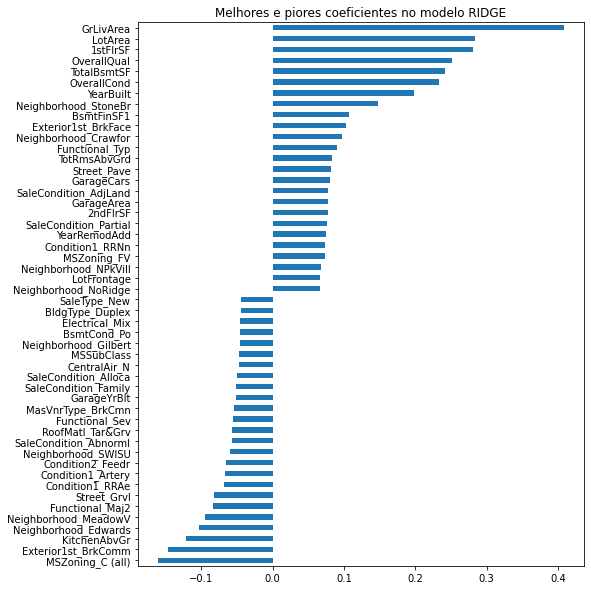

In [27]:
# Os 25 Coeficientes mais relevantes e menos relevantes para o modelo

imp_coef = pd.concat([coef.sort_values().head(25), coef.sort_values().tail(25)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Melhores e piores coeficientes no modelo RIDGE")
plt.show()

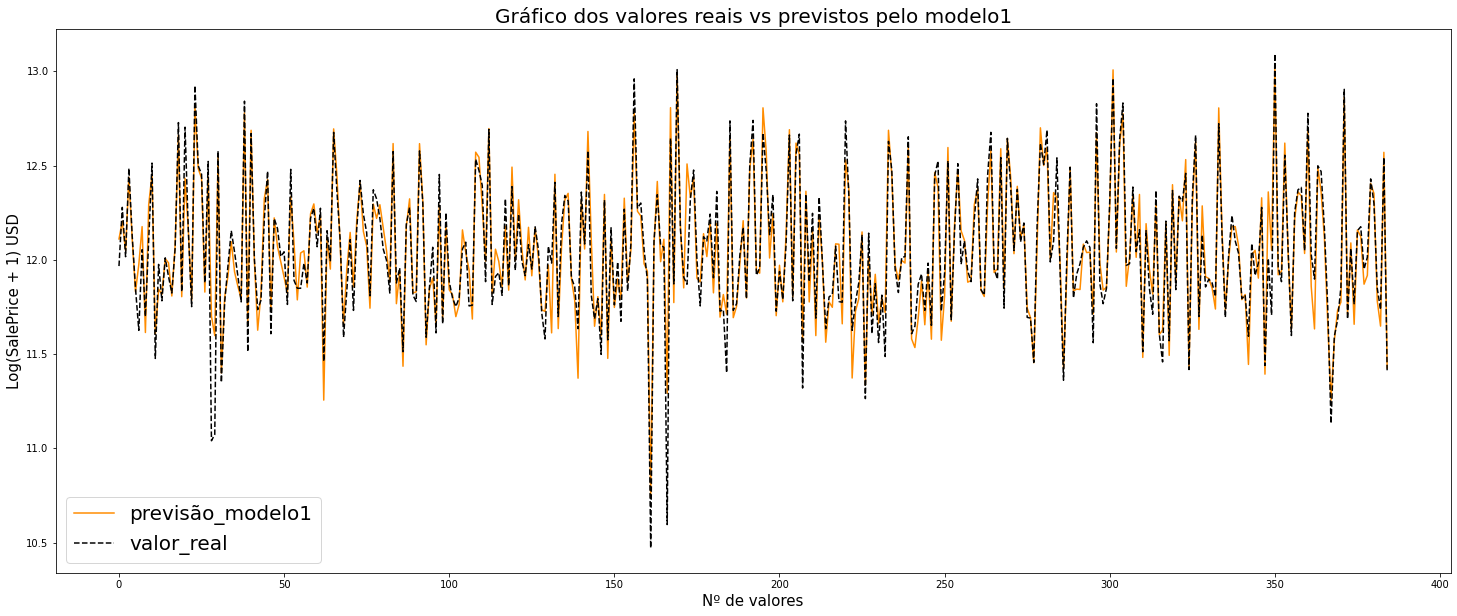

In [28]:
x = df_trat_log.SalePrice.values 

plt.figure(figsize = (25, 10))

plt.plot(y_pred1, color = 'darkorange', label = 'previsão_modelo1')
plt.plot(y_teste, color = 'black', label = 'valor_real', linestyle = '--')

plt.title('Gráfico dos valores reais vs previstos pelo modelo1', fontsize = 20)
plt.xlabel('Nº de valores', fontsize = 15)
plt.ylabel('Log(SalePrice + 1) USD', fontsize = 15)

plt.legend(fontsize = 20)

plt.show()

##### Tabela com os valores reais e a previsão do modelo1

In [29]:
y_teste = pd.Series(y_teste)
y_pred1 = pd.Series(y_pred1)
data = pd.DataFrame(x_teste, columns = variaveis) 
data['SalePrice_real'] = y_teste
data['SalePrice_previsao'] = y_pred1
data[['SalePrice_real','SalePrice_previsao']].round(2).head()

,SalePrice_real,SalePrice_previsao
0,11.97,12.11
1,12.28,12.21
2,12.02,12.05
3,12.49,12.44
4,12.13,12.11


Para inverter a tranformação de **log** utilizamos a sua função inversa **exp**.

In [30]:
data[['SalePrice_real','SalePrice_previsao']] = np.expm1(data[['SalePrice_real','SalePrice_previsao']])
data[['SalePrice_real','SalePrice_previsao']].round(2)

,SalePrice_real,SalePrice_previsao
0,157500.0,181820.00
1,215000.0,199809.74
2,165500.0,170855.80
3,264561.0,252193.70
4,185000.0,182158.48
...,...,...
380,219500.0,231437.66
381,140000.0,130892.88
382,125000.0,114550.23
383,280000.0,287837.00


#### Análise dos erros

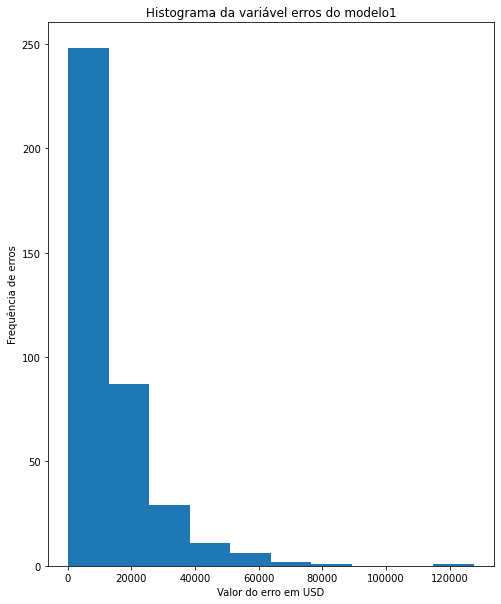

In [38]:
erros = abs(np.expm1(y_pred1) - np.expm1(y_teste))

plt.hist(erros)

plt.title('Histograma da variável erros do modelo1')
plt.xlabel('Valor do erro em USD')
plt.ylabel('Frequência de erros')
plt.show()

Com base no histograma podemos observar que a maior parte do erros do modelo1 ocorreu para valores abaixo de cerca de **30000 USD**, ou seja, se nosso modelo for errar, **há grande chances** de ser um erro de **até 30000 USD** na estimativa do preço de venda de uma casa. Esse valor deve ser discutido com a área de negócio para uma total compreensão das consequências de uma estimativa errada.  

## 5) Conclusão 

O modelo final a ser utilizado para predizer o valor da variável alvo 'SalePrice' é um modelo de regressão linear regularizada RIDGE, definido como **modelo1**, que obteve os seguintes valores nas métricas definidadas:

    R² = 90.37 %
    MAPE = 0.65 % 
    RMSE = 0.12 USD 

A etapa de seleção de variáveis e tratamento de variáveis colineares foi suprimida por conta do algoritmo RIDGE penalizar variáveis colineares e variáveis que não possuem uma forte relação com a variável alvo. 

O dataframe final ficou com:

    1283 registros (linhas)
    265 variáveis preditoras 
    1 variável alvo (SalePrice) 
    
Na análise de erros verificamos que a maior parte, cerca de 340 valores previstos de um total de 385, possuem um erro de estimativa de até 30000 USD. 
    
Os próximos passos são a entrega do **modelo1** para produção, ou seja, utilizar um outro conjunto de dados da área de negócio e fazer as predições. A ideia é fazer acompanhamento junto da área de negócio para validar as futuras predições do modelo, em outras palavras, se o modelo1 está de fato resolvendo o problema para que foi criado, **prever o valor de venda de imóveis** e trazendo resultados **positivos** para a empresa. 